# Basics of Peforming Drainage Simulations with and without Gravity

The PMEAL team recently developed a way to add gravitational effects to the standard drainage simulation algorithm based on sphere insertion, also sometimes called *morphological image opening* or *full morphology*. The paper is available in Water Resources Research. This post will give a brief overview of how to use this new algorithm, which is included in a new function called ``drainage`` located in the ``porespy.filters`` module.  The new ``drainage`` function can produce results with or without gravity effects, creating a more powerful yet flexible function for performing such simulations.

In [1]:
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt
from edt import edt

Start by generating a 2D image of blobs:

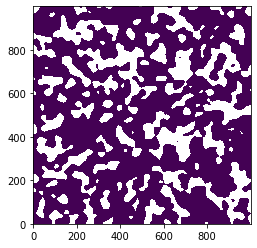

In [2]:
im = ps.generators.blobs([1000, 1000], porosity=0.7, blobiness=2)
ps.imshow(im);

First we'll compute a reference capillary pressure curve with no gravity effects using the new ``drainage`` function. This function requires us to supply an image of capillary pressure values associated with each voxel.  Typicall one would use the Washburn equation:

$$ P_C = -2\sigma \cos (\theta) \bigg(\frac{1}{r}\bigg) $$ 

where ``r`` is conveniently provided by the distance transfer.  This can be computed as follows:

In [3]:
voxel_size = 1e-4  # m/voxel side, a large value is used illustrate the gravity effect
dt = edt(im)  # Obtain the distance transform, using the terrific edt package
pc = -2*0.072*np.cos(np.deg2rad(180))/(dt*voxel_size)  # Apply Washburn equation

The reason for requiring ``pc`` instead of just the boolean ``im`` is to allow users to compute the capillary pressure using any method they wish.  For instance a 2D image of a glass micromodel has a spacing between the plates which can be accounted for as:

$$ P_C = -\sigma \cos (\theta) \bigg(\frac{1}{r} + \frac{1}{s}\bigg) $$

Or ``s`` could be set to ``np.inf`` for a truly 2D simulation.  Computing ``pc`` externally also reduces the number of arguments that must be sent to the ``drainage`` function, by eliminating the surface tension and contact angle. 

In any event, the function is called as follows:

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

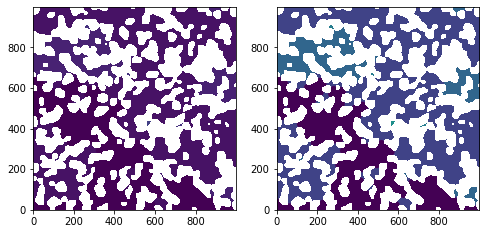

In [4]:
inlets = np.zeros_like(im)
inlets[0, ...] = True
drn = ps.simulations.drainage(pc=pc, im=im, inlets=inlets, voxel_size=voxel_size, g=0)
fig, ax = plt.subplots(1, 2, figsize=[8, 16])
ax[0].imshow(drn.im_pc/im, origin='lower')
ax[1].imshow(np.log10(drn.im_pc), origin='lower');

Both of the above images are colored according to the capillary pressure at which a given voxel was invaded. In the right image we have applied a base-10 logarithm to the values to improve visibility.  The format is handy since it contains the entire invasion sequence in a single image.  

>Note that we have divided the image of invasion pressures by ``im`` to trick matplotlib into showing the solid as white, since ``value/False`` returns ``nan`` while ``value/True`` leaves ``value`` untouched.

Next let's produce a capillary pressure curve.  There are some functions available in ``porespy.metrics`` for this, but the ``drainage`` function takes care of this for us and the needed values are attached to the returned object as attributes:

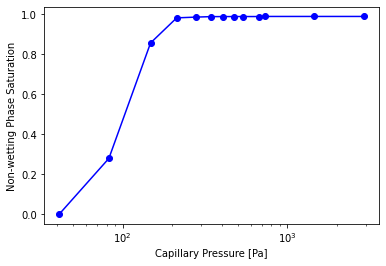

In [5]:
plt.semilogx(drn.pc, drn.snwp, 'b-o')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-wetting Phase Saturation');

Now let's perform the same experiment but including the gravity effects, by setting ``g`` to earth's gravity:

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

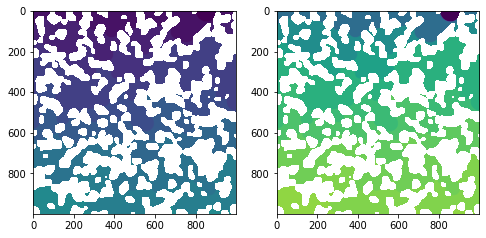

In [6]:
drn2 = ps.simulations.drainage(pc=pc, im=im, inlets=inlets, voxel_size=voxel_size, g=9.81)
fig, ax = plt.subplots(1, 2, figsize=[8, 16])
ax[0].imshow(drn2.im_pc/im)
ax[1].imshow(np.log10(drn2.im_pc));

We can see from the colormap that the invasion pattern is different.  Plotting the capillary pressure curve will make the differences more obvious:

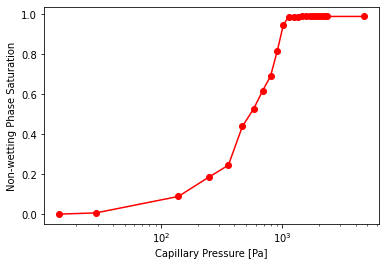

In [7]:
plt.semilogx(drn2.pc, drn2.snwp, 'r-o')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-wetting Phase Saturation');

Combining both plots together for a better comparison:

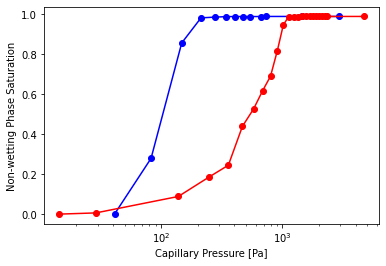

In [8]:
plt.semilogx(drn.pc, drn.snwp, 'b-o')
plt.semilogx(drn2.pc, drn2.snwp, 'r-o')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-wetting Phase Saturation');

The red curve above is shifted to the right with a lower slope.  This is the expected result since the impact of gravity makes it more difficult for the heavy non-wetting fluid to rise up the domain and penetrate into pores. The decreased slope is also expected since pores are invaded more gradually rather than in a larger percolation event.